In [31]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input/df2k-ost'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

In [32]:
len(filenames)

8984

In [33]:
import torch
import torch.nn as nn
from torch import optim

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg19, VGG19_Weights

from PIL import Image
from tqdm.notebook import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
#Configs
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GEN = "gen.pth"
CHECKPOINT_DISC = "disc.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
NUM_EPOCHS = 1000
BATCH_SIZE = 16
LAMBDA_GP = 10
NUM_WORKERS = 2
HIGH_RES = 128
LOW_RES = HIGH_RES // 4
IMG_CHANNELS = 3
mean = np.array([0, 0, 0])
std = np.array([1, 1, 1])

# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])
highres_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
                
    ]
)

lowres_transform = transforms.Compose(
    [
        transforms.Resize(LOW_RES, interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]
)

both_transforms = transforms.Compose(
    [
        transforms.RandomCrop(size=HIGH_RES),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation((0, 90)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
                
    ]
)

In [35]:
from pathlib import Path

# Setup path to data folder
data_path = Path("/kaggle/input/")
image_path = data_path / 'df2k-ost'

import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [36]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '/kaggle/input/df2k-ost'.
There are 2 directories and 0 images in '/kaggle/input/df2k-ost/test'.
There are 0 directories and 300 images in '/kaggle/input/df2k-ost/test/OutdoorSceneTest300'.
There are 0 directories and 100 images in '/kaggle/input/df2k-ost/test/DIV2K_valid'.
There are 3 directories and 0 images in '/kaggle/input/df2k-ost/train'.
There are 0 directories and 2650 images in '/kaggle/input/df2k-ost/train/Flickr2K'.
There are 1 directories and 0 images in '/kaggle/input/df2k-ost/train/DIV2K'.
There are 0 directories and 800 images in '/kaggle/input/df2k-ost/train/DIV2K/DIV2K_train_HR'.
There are 0 directories and 8984 images in '/kaggle/input/df2k-ost/train/OST'.


In [37]:
train_dir = image_path / 'train'
train_dir

PosixPath('/kaggle/input/df2k-ost/train')

Number of images in train_dir: 12434
Random image path: /kaggle/input/df2k-ost/train/OST/sky_1282.png
Image class: OST
Image height: 496
Image width: 328


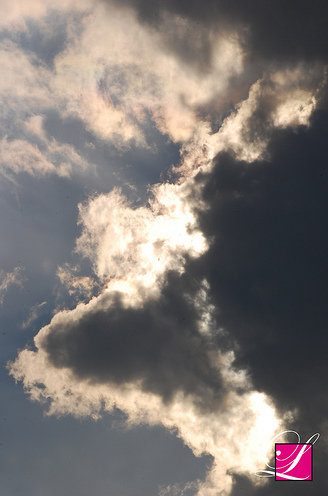

In [38]:
import random
from PIL import Image

# Set seed
random.seed(20) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(train_dir.glob("**/*.png"))
# Print the number of images in the train_dir
print(f"Number of images in train_dir: {len(image_path_list)}")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [39]:
lnew_img = lowres_transform(img)
hnew_img = highres_transform(img)
print(lnew_img.shape)
print(hnew_img.shape)

torch.Size([3, 48, 32])
torch.Size([3, 496, 328])


In [40]:
len(image_path_list)

12434

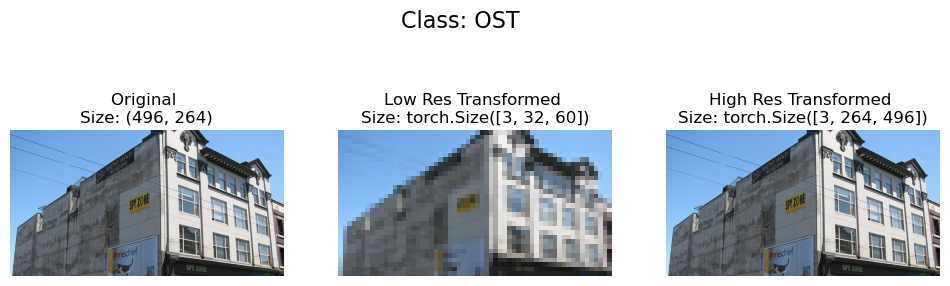

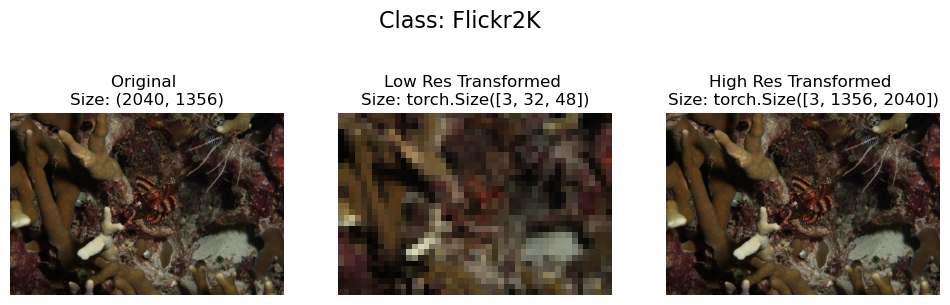

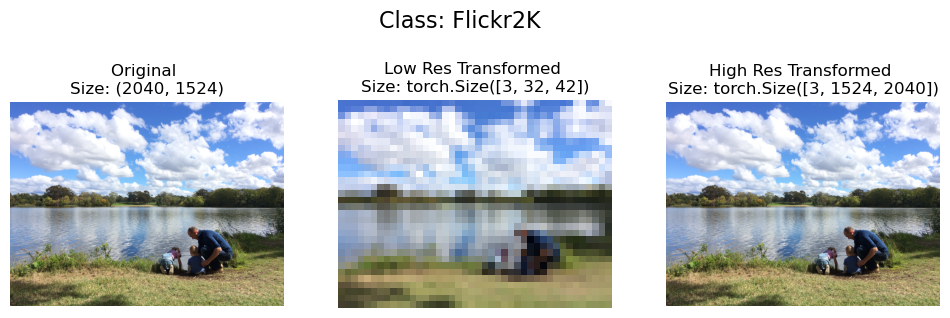

In [41]:
def plot_transformed_images(image_paths, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            #transformed_image = both_transforms(f)
            low_transformed_image = lowres_transform(f)
            high_transformed_image = highres_transform(f)
            
            
            ax[1].imshow(low_transformed_image.permute(1,2,0)) 
            ax[1].set_title(f"Low Res Transformed \nSize: {low_transformed_image.shape}")
            ax[1].axis("off")
            
            ax[2].imshow(high_transformed_image.permute(1,2,0)) 
            ax[2].set_title(f"High Res Transformed \nSize: {high_transformed_image.shape}")
            ax[2].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,n=3)


In [42]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    
    def __init__(self, targ_dir: str):
        
        self.paths = list(targ_dir.glob("**/*.png")) 

    def load_image(self, index: int):
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    def __getitem__(self, index: int):
        img = self.load_image(index)
        img = both_transforms(img)
        high_res = highres_transform(img)
        low_res = lowres_transform(img)
        
        return low_res, high_res

        
def test():
    dataset = ImageFolderCustom(targ_dir=train_dir) 
    loader = DataLoader(dataset, batch_size=1, num_workers=2)
    print(len(dataset))
    for low_res, high_res in loader:
        pass
        #print(low_res.shape)
        #print(high_res.shape)


#if __name__ == "__main__":
   # test()

In [43]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir) 
len(train_data_custom)                                  

12434

In [44]:
from torchvision.models import vgg

class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(weights=VGG19_Weights.DEFAULT).features[:36].eval().to(DEVICE)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)

In [45]:
from torchvision.utils import save_image

def gradient_penalty(critic, real, fake, device):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake.detach() * (1 - alpha)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    #print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def plot_examples(low_res_folder, gen):
    files = os.listdir(low_res_folder)

    gen.eval()
    for file in files:
        image = Image.open("test_images/" + file)
        with torch.no_grad():
            upscaled_img = gen(
                test_transform(image=np.asarray(image))
                .unsqueeze(0)
                .to(DEVICE)
            )
        save_image(upscaled_img * 0.5 + 0.5, f"saved/{file}")
    gen.train()

In [46]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, **kwargs):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            **kwargs,
            bias=True,
        )
        self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()

    def forward(self, x):
        return self.act(self.cnn(x))


class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.conv = nn.Conv2d(in_c, in_c, 3, 1, 1, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))


class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, channels=32, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.blocks = nn.ModuleList()

        for i in range(5):
            self.blocks.append(
                ConvBlock(
                    in_channels + channels * i,
                    channels if i <= 3 else in_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    use_act=True if i <= 3 else False,
                )
            )

    def forward(self, x):
        new_inputs = x
        for block in self.blocks:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)
        return self.residual_beta * out + x


class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

    def forward(self, x):
        return self.rrdb(x) * self.residual_beta + x


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
        super().__init__()
        self.initial = nn.Conv2d(
            in_channels,
            num_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
        )
        self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.upsamples = nn.Sequential(
            UpsampleBlock(num_channels), UpsampleBlock(num_channels),
        )
        self.final = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, in_channels, 3, 1, 1, bias=True),
        )

    def forward(self, x):
        initial = self.initial(x)
        x = self.conv(self.residuals(initial)) + initial
        x = self.upsamples(x)
        return self.final(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    use_act=True,
                ),
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)

def initialize_weights(model, scale=0.1):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale

        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale


def test():
    gen = Generator()
    disc = Discriminator()
    low_res = 24
    x = torch.randn((5, 3, low_res, low_res))
    gen_out = gen(x)
    disc_out = disc(gen_out)

    print(gen_out.shape)
    print(disc_out.shape)

if __name__ == "__main__":
    test()

torch.Size([5, 3, 96, 96])
torch.Size([5, 1])


In [47]:
MODEL_PATH = Path("saved-weights")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

In [48]:
disc_path = Path('/kaggle/input/saved-weight/dis131.pth')
disc = Discriminator().to(DEVICE)
disc.load_state_dict(torch.load(f=disc_path, map_location=DEVICE))

In [49]:
gen_path = Path('/kaggle/input/saved-weight/gen131.pth')
gen = Generator().to(DEVICE)
gen.load_state_dict(torch.load(f=gen_path, map_location=DEVICE))

In [50]:
torch.backends.cudnn.benchmark = True

def train_fn(
    loader,
    disc,
    gen,
    opt_gen,
    opt_disc,
    l1,
    vgg_loss,
    g_scaler,
    d_scaler,
    #writer,
    tb_step,
):
    loop = tqdm(loader, leave=False)
    for idx, (low_res, high_res) in enumerate (loop):
        high_res = high_res.to(DEVICE)
        low_res = low_res.to(DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(low_res)
            critic_real = disc(high_res)
            critic_fake = disc(fake.detach())
            gp = gradient_penalty(disc, high_res, fake, device=DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + LAMBDA_GP * gp
            )

        opt_disc.zero_grad()
        d_scaler.scale(loss_critic).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        with torch.cuda.amp.autocast():
            l1_loss = 1e-2 * l1(fake, high_res)
            adversarial_loss = 5e-3 * -torch.mean(disc(fake))
            loss_for_vgg = vgg_loss(fake, high_res)
            gen_loss = l1_loss + loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        g_scaler.scale(gen_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        #writer.add_scalar("Critic loss", loss_critic.item(), global_step=tb_step)
        tb_step += 1

#         if idx % 100 == 0 and idx > 0:
#             plot_examples("test_images/", gen)

        loop.set_postfix(
            gp=gp.item(),
            critic=loss_critic.item(),
            l1=l1_loss.item(),
            vgg=loss_for_vgg.item(),
            adversarial=adversarial_loss.item(),
        )

    return tb_step


def main():
    dataset = train_data_custom
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )
    #gen = Generator(in_channels=3).to(DEVICE)
    #disc = Discriminator(in_channels=3).to(DEVICE)
    initialize_weights(gen)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
   # writer = SummaryWriter("logs")
    tb_step = 0
    l1 = nn.L1Loss()
    gen.train()
    disc.train()
    vgg_loss = VGGLoss()

    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

#     if LOAD_MODEL:
#         load_checkpoint(
#             CHECKPOINT_GEN,
#             gen,
#             opt_gen,
#             LEARNING_RATE,
#         )
#         load_checkpoint(
#             CHECKPOINT_DISC,
#             disc,
#             opt_disc,
#             LEARNING_RATE,
#         )


    for epoch in tqdm(range(NUM_EPOCHS)):
        tb_step = train_fn(
            loader,
            disc,
            gen,
            opt_gen,
            opt_disc,
            l1,
            vgg_loss,
            g_scaler,
            d_scaler,
            #writer,
            tb_step,
        )

#         if SAVE_MODEL and epoch % 10 ==0:
        if epoch % 10 == 0:
            #save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            #save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)
            GEN_NAME = f"gen{epoch}.pth"
            GEN_SAVE_PATH = MODEL_PATH / GEN_NAME
            DIS_NAME = f"dis{epoch}.pth"
            DIS_SAVE_PATH = MODEL_PATH / DIS_NAME


            # Save the model state dict
            print(f"Saving model to: {GEN_SAVE_PATH}")
            torch.save(obj=gen.state_dict(), # only saving the state_dict() only saves the learned parameters
                       f=GEN_SAVE_PATH)

            print(f"Saving model to: {DIS_SAVE_PATH}")
            torch.save(obj=disc.state_dict(), # only saving the state_dict() only saves the learned parameters
                       f=DIS_SAVE_PATH)

if __name__ == "__main__":
    try_model = False

    if try_model:
        # Will just use pretrained weights and run on images
        # in test_images/ and save the ones to SR in saved/
        gen = Generator(in_channels=3).to(DEVICE)
        opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
        load_checkpoint(
            CHECKPOINT_GEN,
            gen,
            opt_gen,
            LEARNING_RATE,
        )
        #plot_examples("test_images/", gen)
    else:
        #pass
        # This will train from scratch
        main()

In [51]:
# while True:
#     pass

In [53]:
gen_path = Path('/kaggle/input/saved-weight/gen131.pth')
gen_load = Generator().to(DEVICE)
gen_load.load_state_dict(torch.load(f=gen_path, map_location=DEVICE))

<All keys matched successfully>

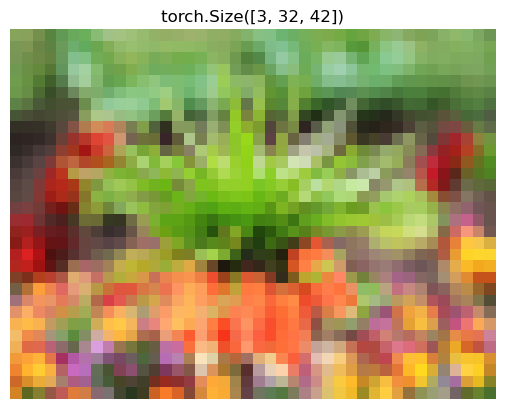

In [54]:
test_image_path = Path('/kaggle/input/df2k-ost/test/DIV2K_valid/0803.png')
test_image = Image.open(test_image_path)
test_image_transformed = lowres_transform(test_image)
plt.title(test_image_transformed.shape)
plt.imshow(test_image_transformed.permute(1,2,0))
plt.axis('off')
plt.show()
plt.savefig('/kaggle/working/lres_input.png')

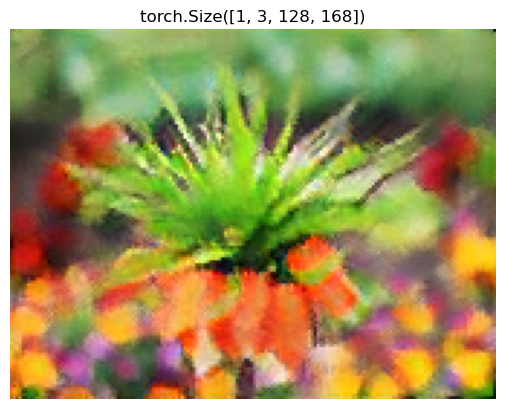

In [55]:
with torch.inference_mode():
    out = gen_load(test_image_transformed.unsqueeze(0).to(DEVICE))
    plt.title(out.shape)
    plt.imshow(out.squeeze().cpu().permute(1,2,0))
    plt.axis('off')
    plt.show()
    plt.savefig('/kaggle/working/hres_output.png')    